# Installing Dependencies

In [ ]:
!pip install netCDF4
!pip install azure-storage-blob
!pip install tqdm
!pip install matplotlib
!pip install basemap
!pip install cartopy

  Using cached Cartopy-0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.9 kB)
Using cached Cartopy-0.24.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)


# Importing Libraries

In [ ]:
import os
import gzip
import tempfile
import numpy as np
import shutil
import urllib
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from datetime import datetime, timedelta

import netCDF4
from azure.storage.blob import ContainerClient
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap


# Defining Cloud Retrival Details for Dataset

In [ ]:
grid_file_url = 'https://ghe.blob.core.windows.net/noaa-ghe/NPR.GEO.GHE.v1.Navigation.netcdf.gz'
dir = '/content/ghe'
storage_account_name = 'ghe'
container_name = 'noaa-ghe'
storage_account_url = 'https://' + storage_account_name + '.blob.core.windows.net'
ghe_blob_root = storage_account_url + '/' + container_name + '/'

ghe_container_client = ContainerClient(account_url=storage_account_url,
                                         container_name=container_name,
                                         credential=None)

In [ ]:
def download_url(url, destination_dir):
    os.makedirs(destination_dir, exist_ok=True)
    url_as_filename = url.replace('://', '_').replace('/', '_')
    destination_filename = os.path.join(destination_dir,url_as_filename)
    urllib.request.urlretrieve(url, destination_filename)
    return destination_filename

# Visualizing Sample From Dataset

## Downloading Lat-Long File From The Cloud


In [ ]:
# Downloading Lat-Long File From Cloud
grid_filename_gz = download_url(grid_file_url, dir)
with gzip.open(grid_filename_gz) as gz:
    grid_dataset = netCDF4.Dataset('dummy', mode='r', memory=gz.read())
    print(grid_dataset.variables)
    lat_grid_raw = grid_dataset['latitude'][:]
    lon_grid_raw = grid_dataset['longitude'][:]

{'latitude': <class 'netCDF4.Variable'>
float32 latitude(lines, elems)
    long_name: latitude of GHE (positive North)
    units: degrees
    parameter_type: GHE rain
    valid_range: [-65.  65.]
    _FillValue: -9999.0
unlimited dimensions: 
current shape = (4800, 10020)
filling on, 'longitude': <class 'netCDF4.Variable'>
float32 longitude(lines, elems)
    long_name: longitude of GHE (positive East)
    units: degrees
    parameter_type: GHE rain
    valid_range: [-180.  180.]
    _FillValue: -9999.0
unlimited dimensions: 
current shape = (4800, 10020)
filling on}


## Retrieving Samples For a Specific Date

In [ ]:
# Collecting URLs for all samples on specific date

product = 'rain_rate'
syear = '2022'; smonth = '07'; sday = '05'
prefix = product + '/' + syear + '/' + smonth + '/' + sday

generator = ghe_container_client.list_blobs(name_starts_with=prefix)
blob_urls = []
for blob in generator:
    blob_urls.append(ghe_blob_root + blob.name)

print('Found {} matching scans'.format(len(blob_urls)))

Found 96 matching scans


In [ ]:
# Define the destination directory for images and retrieving one 15-min interval image from the day

i = 95 - 20
sample_output_dir = '/content/ghe/samples/'
os.makedirs(sample_output_dir, exist_ok=True)
filename = download_url(blob_urls[i], sample_output_dir)
print('Downloaded {}'.format(filename))
imagename = blob_urls[i].split('.')[-3]

# Define coloring scheme for plot
plasma_cmap = plt.get_cmap('plasma')
print(len(range(1, plasma_cmap.N)))
colors = [(1, 1, 1)] + [plasma_cmap(i) for i in range(1, plasma_cmap.N)] # Adding (1,1,1) makes sure 0 intensity is white
custom_cmap_A = LinearSegmentedColormap.from_list("white_to_plasma", colors, N=256)

# Define coloring scheme for plot
turbo_cmap = plt.get_cmap('turbo')
print(len(range(1, turbo_cmap.N)))
colors = [(1, 1, 1)] + [turbo_cmap(i) for i in range(1, turbo_cmap.N)] # Adding (1,1,1) makes sure 0 intensity is white
custom_cmap_B = LinearSegmentedColormap.from_list("white_to_plasma", colors, N=256)

# Defining region of interest
min_lat, max_lat = 23.65101718199114, 28.571809429628
min_lon, max_lon = 66.40570152424772, 71.273030867477
lat_grid_raw = np.array(lat_grid_raw)
lon_grid_raw = np.array(lon_grid_raw)

# Find the indices for the latitude and longitude bounds as in the previous code snippet
lat_indices = np.where((lat_grid_raw[:, 0] >= min_lat) & (lat_grid_raw[:, 0] <= max_lat))[0]
lon_indices = np.where((lon_grid_raw[0, :] >= min_lon) & (lon_grid_raw[0, :] <= max_lon))[0]

# Extract the latitude and longitude grid for plotting
lat_subset = lat_grid_raw[lat_indices.min():lat_indices.max()+1, 0]
lon_subset = lon_grid_raw[0, lon_indices.min():lon_indices.max()+1]

# Openning downloaded file/sample
with gzip.open(filename) as gz:
    dataset = netCDF4.Dataset('dummy', mode='r', memory=gz.read())

# Extract rainfall data for the current 15-minute interval
precipitation = np.array(dataset['rain'][:])
precipitation[precipitation < 0] = 0  # Remove fill values
precipitation_subset = precipitation[lat_indices.min():lat_indices.max()+1, lon_indices.min():lon_indices.max()+1]
print(precipitation_subset.shape, lat_subset.shape ,lon_subset.shape)
dataset.close()

Downloaded /content/ghe/samples/https_ghe.blob.core.windows.net_noaa-ghe_rain_rate_2022_07_05_NPR.GEO.GHE.v1.S202207051845.nc.gz
255
255
(153, 135) (153,) (135,)


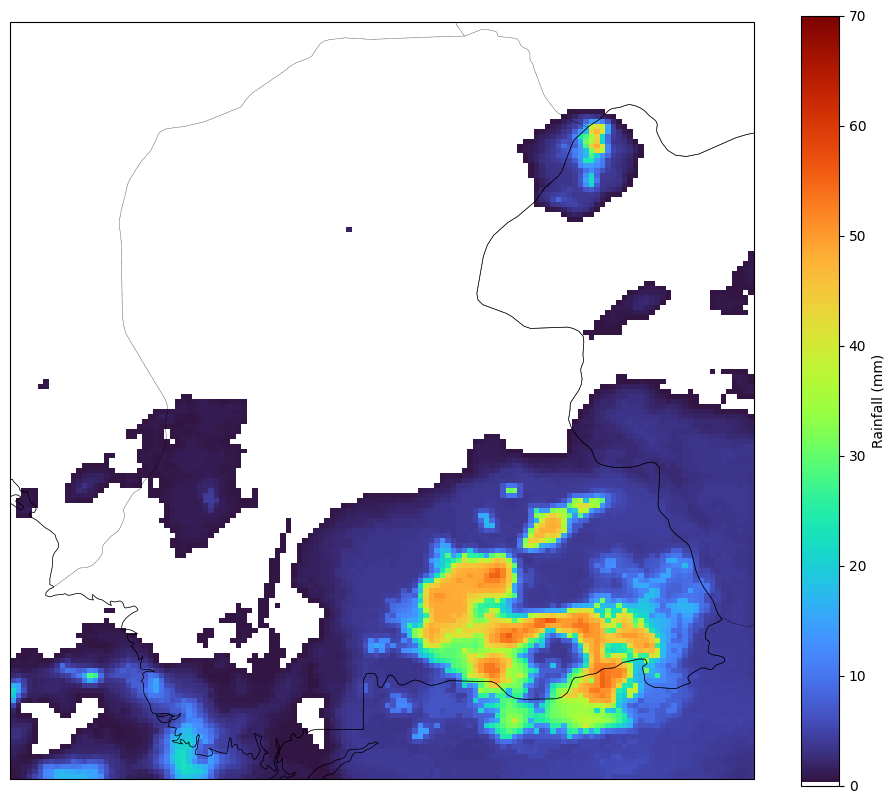

In [ ]:
# Plotting with Cartopy for regional boundaries
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_facecolor("white")  # Set background to white

# Add country and state/provincial boundaries
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.5, edgecolor='black')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.STATES, linestyle=':', linewidth=0.3)  # For finer boundaries, if desired

# Plot the rainfall data
rain_plot = ax.pcolormesh(lon_subset, lat_subset, precipitation_subset, shading='auto', cmap=custom_cmap_B, transform=ccrs.PlateCarree(), vmin=0, vmax=70)
plt.colorbar(rain_plot, ax=ax, orientation='vertical', label='Rainfall (mm)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()